In [1]:
import deepxde as dde
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from naca4digit_airfoil import Naca4DigitAirfoil
from navier_stokes import NavierStokesPDEs
import utils
import pandas as pd
from scipy.interpolate import griddata

/Users/ggito/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
x_min = -0.25
x_max = 0.75
y_min = -0.25
y_max = 0.25

In [3]:
dde.config.set_random_seed(48)
dde.config.set_default_float('float64')
dde.config.set_parallel_scaling('strong')

Set the default float type to float64


In [4]:
rho  = 1.225
mu   = 0.44725e-7
# mu   = 1.789e-5
u_inlet  = 0.75
# u_inlet  = 15
L = 0.05
# L = 1

Re = rho * u_inlet * L / mu

In [5]:
rho, mu, u_inlet, L, Re

(1.225, 4.4725e-08, 0.75, 0.05, 1027110.1173840136)

In [6]:
airfoil = Naca4DigitAirfoil(c=L, M=2, P=4, T=12, a=0, offset_x=0, offset_y=0)

In [7]:
# Geometry defintion
farfield = dde.geometry.Rectangle([x_min, y_min], [x_max, y_max])
airfoil_geom  = dde.geometry.Polygon(airfoil.get_boundary_points(250))
geom     = dde.geometry.CSGDifference(farfield, airfoil_geom)

inner_rec  = dde.geometry.Rectangle([-0.5/20, -0.5/20], [0.5/20, 0.5/20])
inner_dom  = dde.geometry.CSGDifference(inner_rec, airfoil_geom)

mid_rec  = dde.geometry.Rectangle([-2.5/20, -1/20], [5/20, 1/20])
mid_dom  = dde.geometry.CSGDifference(mid_rec, inner_rec)
mid_dom  = dde.geometry.CSGDifference(mid_dom, airfoil_geom)

outer_dom  = dde.geometry.CSGDifference(farfield, inner_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, mid_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, airfoil_geom)

In [9]:
Nf1 = 2**14 # = 16384
Nf2 = 2**14 # = 16384
Nf3 = 2**16 # = 65536
Nb  = 2**11 # = 2048
Ns  = 250

random = "Sobol"
inner_points = inner_dom.random_points(Nf1, random=random)
mid_points = mid_dom.random_points(Nf2, random=random)
outer_points = outer_dom.random_points(Nf3, random=random)

farfield_points = farfield.random_boundary_points(Nb, random=random)
airfoil_points  = airfoil.get_boundary_points(Ns)

static_points = np.append(inner_points, mid_points, axis = 0)
static_points = np.append(static_points, airfoil_points, axis = 0)
static_points = np.append(static_points, farfield_points, axis = 0)


(-0.35, 0.35)

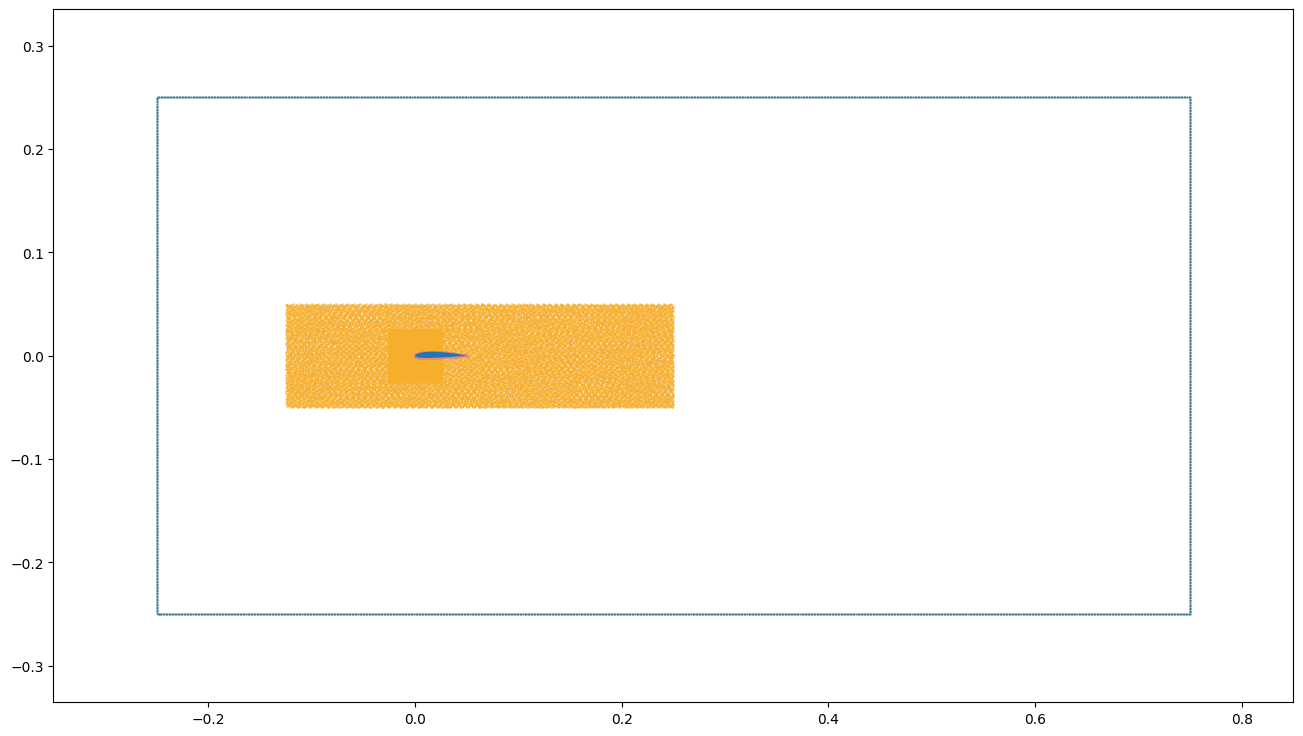

In [10]:
fig1, ax1 = plt.subplots(figsize = (16, 9))
plt.axis('equal')
plt.scatter(farfield_points[:, 0], farfield_points[:, 1], s = 0.3, c='#40798C')
plt.scatter(inner_points[:, 0], inner_points[:, 1], s = 0.3, c = '#F6AE2D')
plt.scatter(mid_points[:, 0], mid_points[:, 1], s = 0.3, c = '#F6AE2D')
plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.3, c = '#E9897E')
plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])
plt.xlim([x_min - 0.1, x_max + 0.1])
plt.ylim([y_min - 0.1, y_max + 0.1])

In [11]:
navier_stokes_pdes = NavierStokesPDEs(rho=rho, mu=mu,
                                      xmin=x_min, xmax=x_max, ymin=y_min, ymax=y_max,
                                      airfoil_geom=airfoil_geom, geom=geom,
                                      u_inlet=u_inlet, v_farfield=0)

pdes_fun = navier_stokes_pdes.get_pdes
bcs = navier_stokes_pdes.get_bcs()

In [12]:
# Problem setup
data = dde.data.PDE(geom, pdes_fun, bcs, num_domain = Nf3, num_boundary = 0, num_test = 1000, anchors = static_points, train_distribution = "Hammersley")

(-0.3, 0.8, -0.275, 0.275)

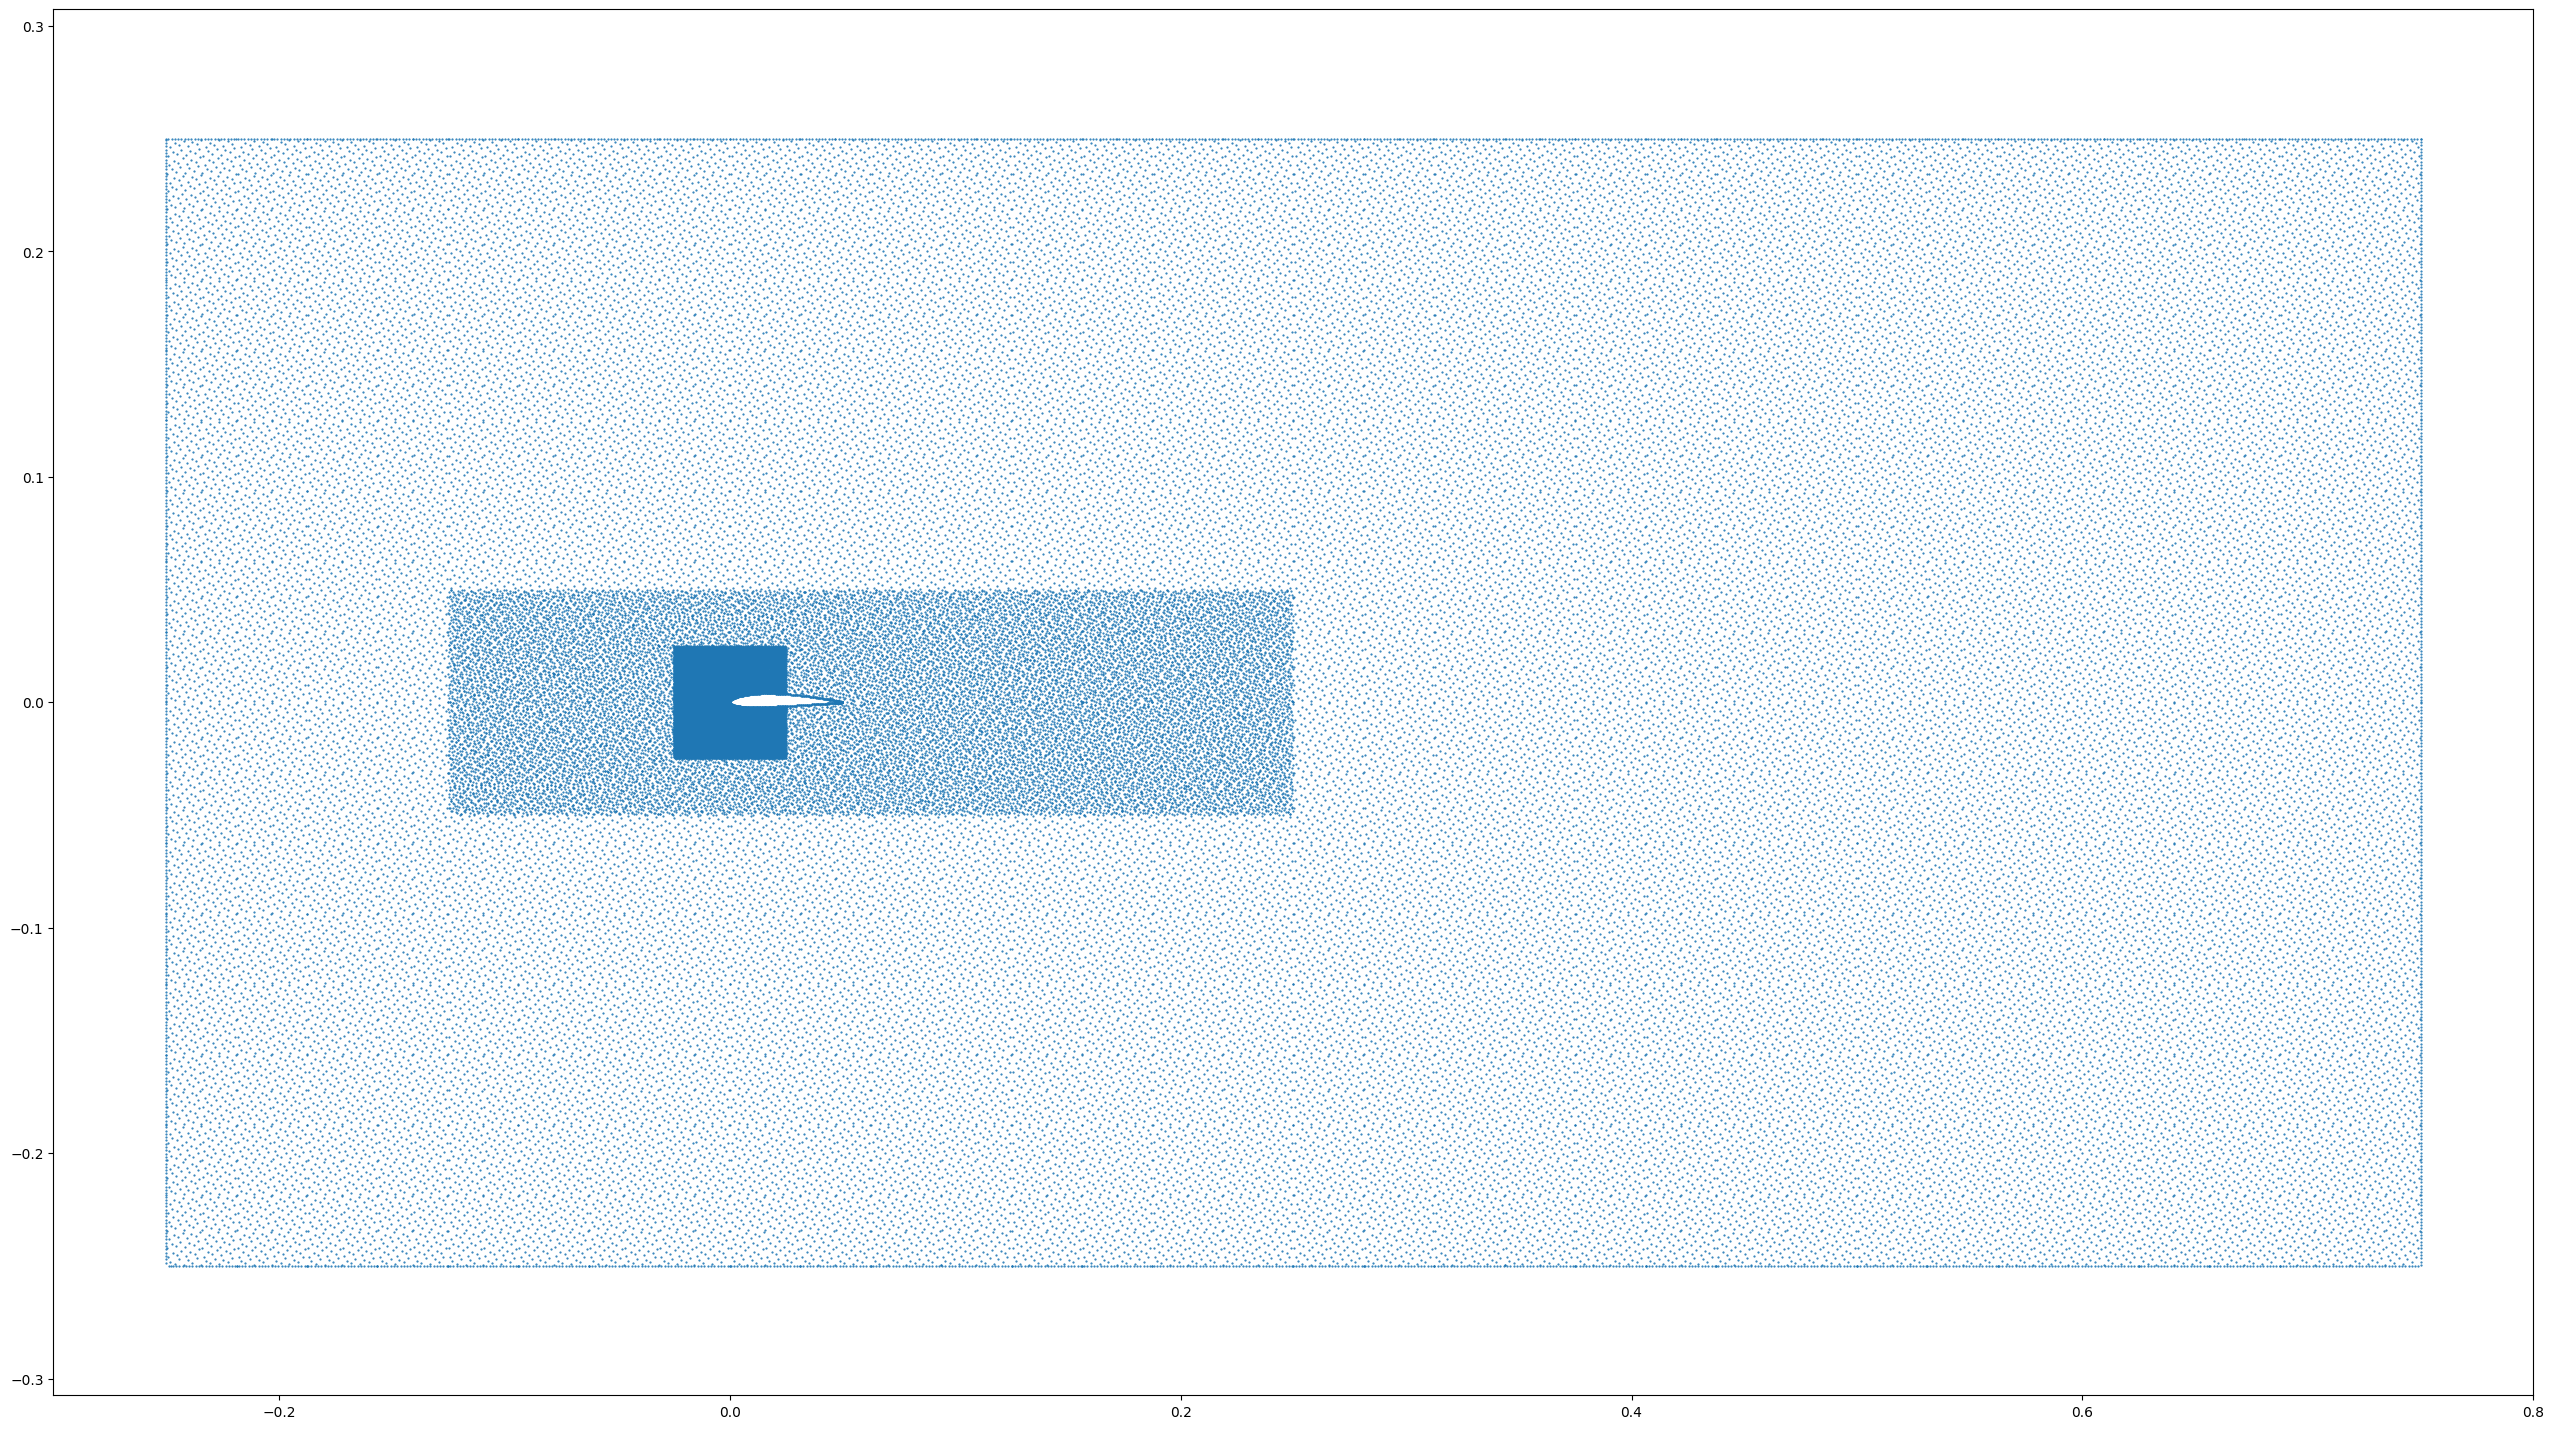

In [13]:
plt.figure(figsize = (32, 18))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.3)
plt.axis('equal')

In [14]:
# Neural network definition
layer_size  = [2] + [32] * 10 + [5]
activation  = 'tanh'
initializer = 'Glorot uniform'

net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

In [25]:
name_generator = utils.NameGenerator()
model_name = name_generator.generate_name()
model_name

'WindPreciseGalaxy278'

In [26]:
model.compile(optimizer = 'adam', lr = 5e-4, loss_weights=[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

Compiling model...
'compile' took 0.005868 s



In [27]:
resampler = dde.callbacks.PDEPointResampler(period = 100, pde_points=True, bc_points=False)

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
70000     [3.43e-05, 9.43e-06, 2.26e-06, 1.62e-06, 3.80e-06, 2.74e-07, 1.62e-05, 8.46e-06, 1.81e-07, 2.93e-06, 2.27e-08]    [1.99e-05, 5.76e-06, 2.76e-06, 1.96e-06, 4.00e-06, 3.16e-07, 1.62e-05, 8.46e-06, 1.81e-07, 2.93e-06, 2.27e-08]    []  
70050     [7.65e-05, 6.89e-06, 2.50e-06, 1.68e-06, 4.04e-06, 3.99e-07, 2.58e-06, 8.69e-06, 2.04e-07, 6.52e-06, 9.48e-09]    [4.34e-05, 5.66e-06, 3.03e-06, 1.99e-06, 3.97e-06, 4.41e-07, 2.58e-06, 8.69e-06, 2.04e-07, 6.52e-06, 9.48e-09]    []  
70100     [2.42e-04, 2.75e-05, 4.02e-06, 1.79e-06, 3.98e-06, 1.04e-06, 4.18e-05, 9.92e-06, 2.91e-07, 4.09e-06, 4.58e-08]    [1.27e-04, 1.51e-05, 4.74e-06, 2.05e-06, 4.05e-06, 1.11e-06, 4.18e-05, 9.92e-06, 2.91e-07, 4.09e-06, 4.58e-08]    []  
70

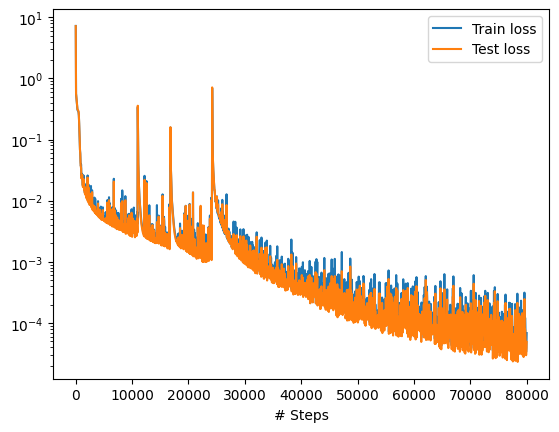

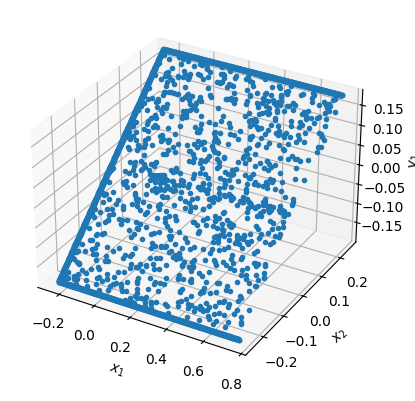

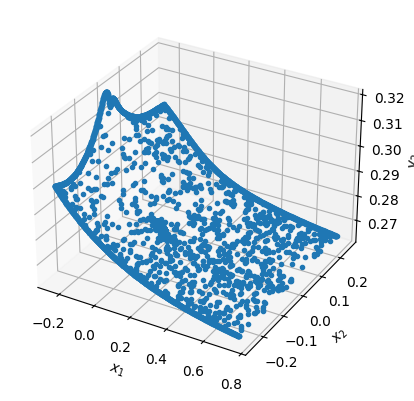

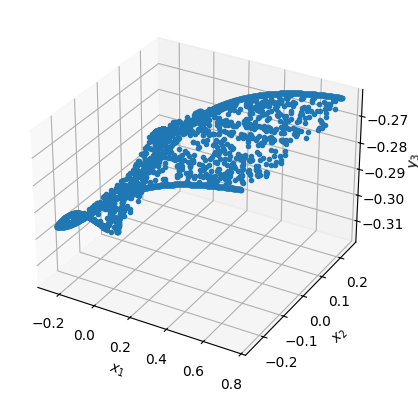

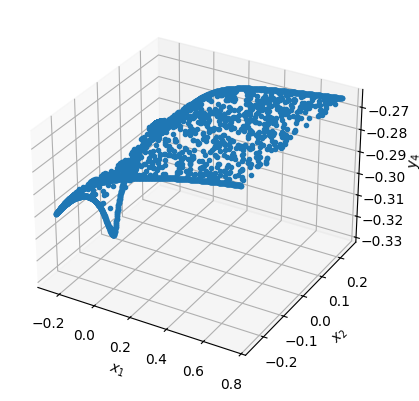

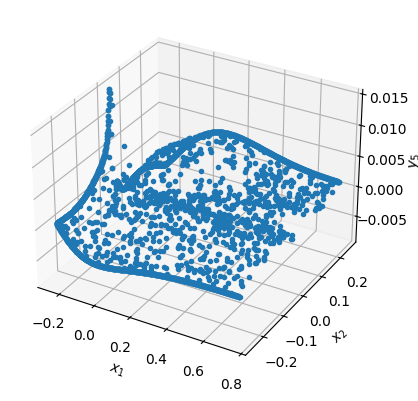

In [48]:
try:
  losshistory, train_state = model.train(epochs = 10000, display_every = 50, callbacks=[resampler], model_save_path = './' + model_name + '/')
  dde.saveplot(losshistory, train_state, issave = True, isplot = True)

except KeyboardInterrupt:
  print(f"Training stopped by user.")
  print("=======================================================")

In [49]:
dy = 0.025
dx = 0.025
x = np.arange(x_min, x_max + dy, dx)
y = np.arange(y_min, y_max + dy, dy)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

In [50]:
# Model predictions generation
u = model.predict(X, operator = navier_stokes_pdes.getU)
v = model.predict(X, operator = navier_stokes_pdes.getV)
p = model.predict(X, operator = navier_stokes_pdes.getP)

In [51]:
# save results to csv
df = pd.DataFrame(data = {'x': xs, 'y': ys, 'u': u.reshape(-1), 'v': v.reshape(-1), 'p': p.reshape(-1)})
df.to_csv('results.csv', index=False)

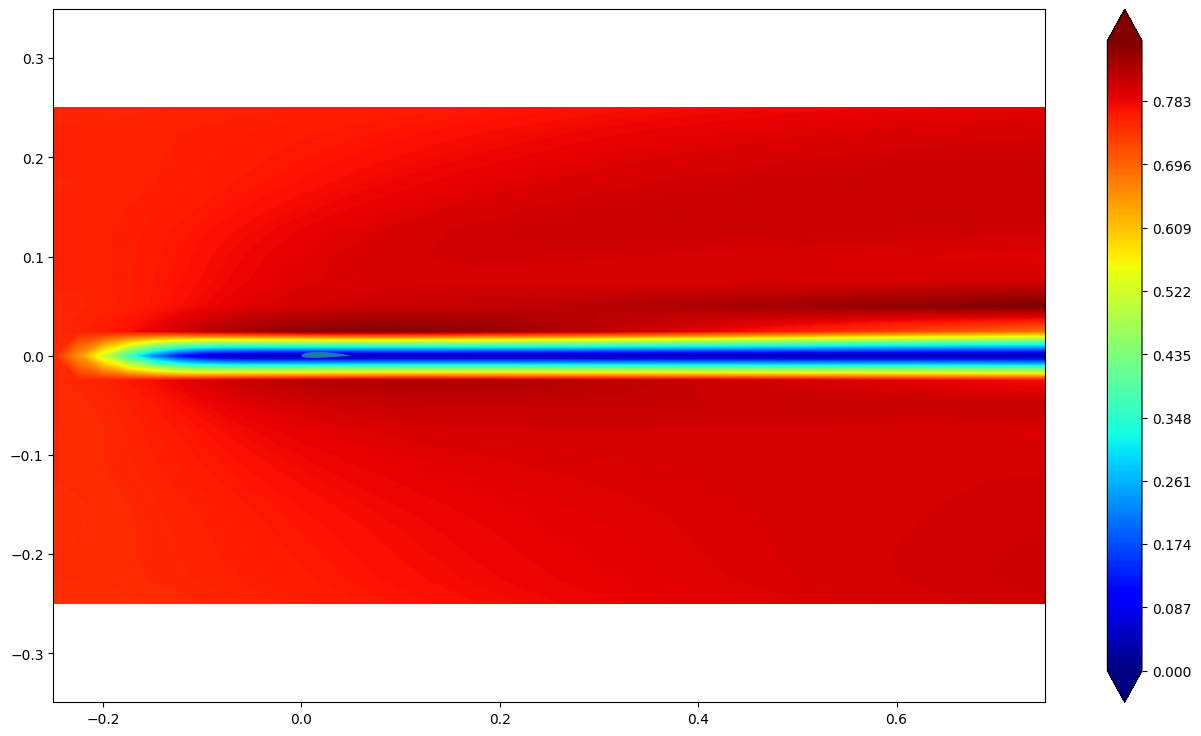

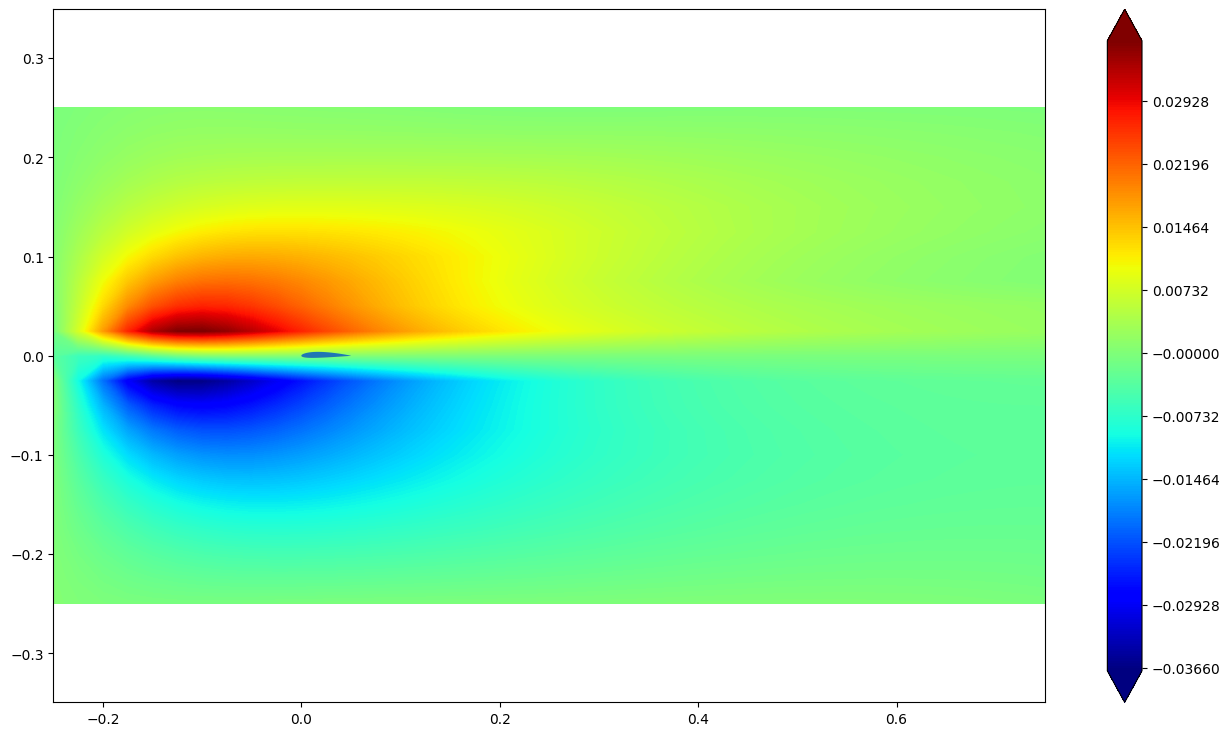

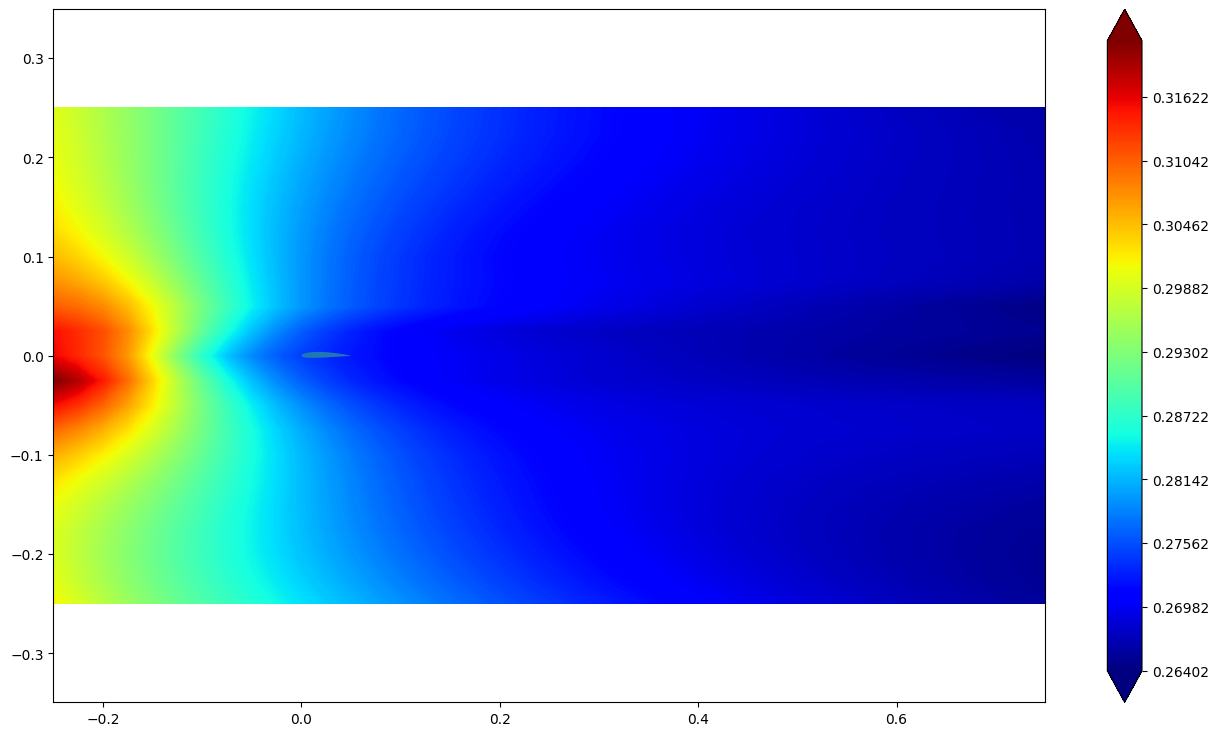

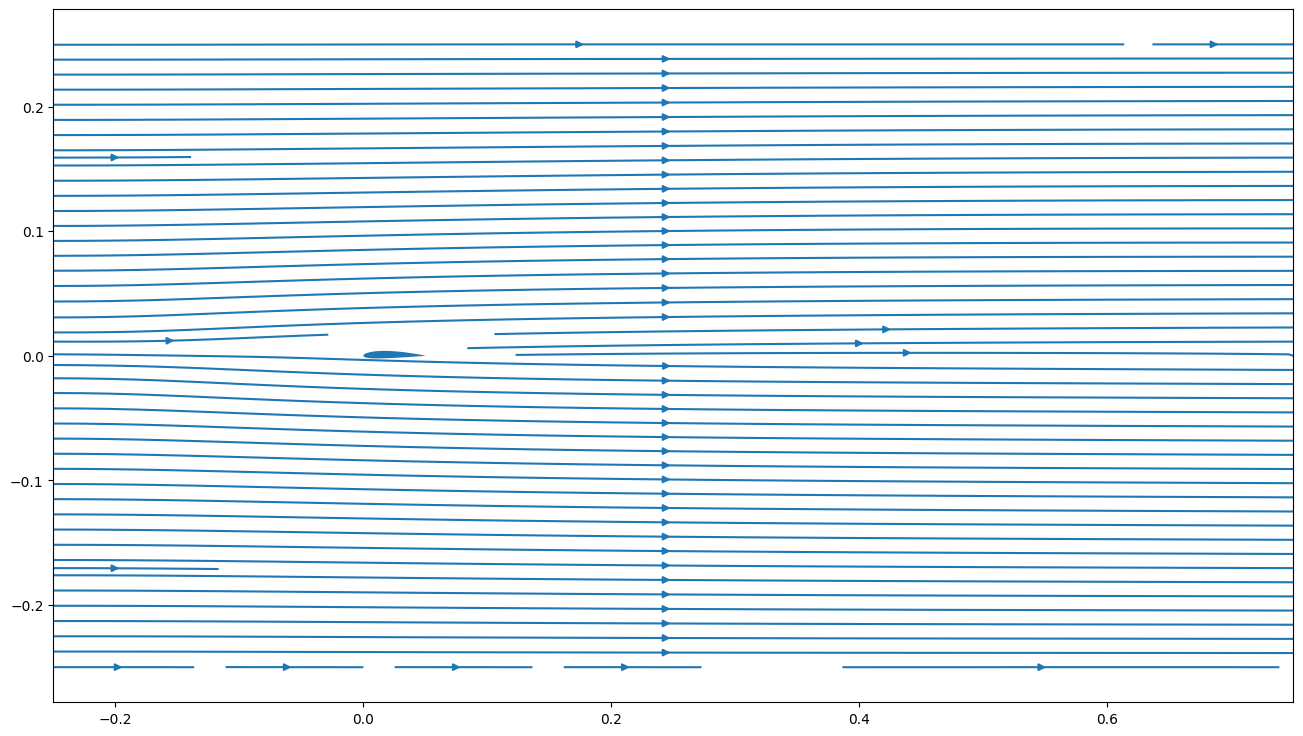

In [52]:
for i in range(len(X)):
   if airfoil_geom.inside(np.array([X[i]]))[0]:
       u[i] = 0.0
       v[i] = 0.0

u = u.reshape(len(y), len(x))
v = v.reshape(len(y), len(x))
p = p.reshape(len(y), len(x))

airfoil_plot = airfoil.get_boundary_points(150)

fig1, ax1 = plt.subplots(figsize = (16, 9))
clev = np.arange(u.min(), u.max(), 0.001)
cnt1 = ax1.contourf(x, y, u, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig1.colorbar(cnt1)
plt.savefig('./u.png')

fig2, ax2 = plt.subplots(figsize = (16, 9))
clev = np.arange(v.min(), v.max(), 0.00001)
cnt2 = ax2.contourf(x, y, v, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig2.colorbar(cnt2)
plt.savefig('./v.png')

fig3, ax3 = plt.subplots(figsize = (16, 9))
clev = np.arange(p.min(), p.max(), 0.0001)
cnt3 = ax3.contourf(x, y, p, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig3.colorbar(cnt3)
plt.savefig('./p.png')

fig4, ax4 = plt.subplots(figsize = (16, 9))
ax4.streamplot(x, y, u, v, density = 1.5)
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
plt.savefig('./f.png')